## MNIST Classifier

### Frame the problem

4. This particular Problem is unsupervised, and offline.
5. The prompt is to measure performance with accuracy.
7. The minimum accuracy is 97%

### Get the data

In [29]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import expon

from sklearn.datasets import fetch_openml
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.model_selection import cross_val_predict
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier

In [19]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [20]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [21]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Explore the data

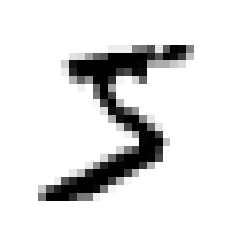

In [22]:
some_digit = X_train[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

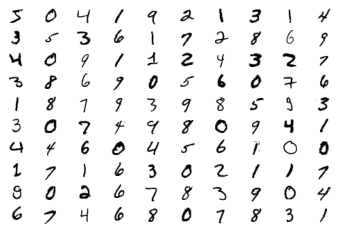

array([['5', '0', '4', '1', '9', '2', '1', '3', '1', '4'],
       ['3', '5', '3', '6', '1', '7', '2', '8', '6', '9'],
       ['4', '0', '9', '1', '1', '2', '4', '3', '2', '7'],
       ['3', '8', '6', '9', '0', '5', '6', '0', '7', '6'],
       ['1', '8', '7', '9', '3', '9', '8', '5', '9', '3'],
       ['3', '0', '7', '4', '9', '8', '0', '9', '4', '1'],
       ['4', '4', '6', '0', '4', '5', '6', '1', '0', '0'],
       ['1', '7', '1', '6', '3', '0', '2', '1', '1', '7'],
       ['9', '0', '2', '6', '7', '8', '3', '9', '0', '4'],
       ['6', '7', '4', '6', '8', '0', '7', '8', '3', '1']], dtype=object)

In [23]:
rows, cols = 10, 10
fig, axs = plt.subplots(rows, cols)
for i, digit in enumerate(X_train[:rows*cols]):
    digit_image = digit.reshape(28, 28)
    row = i // rows
    col = i % rows
    axs[row, col].imshow(digit_image, cmap="binary")
    axs[row, col].axis("off")
plt.show() 
y_train[:rows*cols].reshape((rows, cols))

In [24]:
y[0]

'5'

### Clean the data

In [25]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
cat_encoder = OneHotEncoder()
y_train_one_hot = cat_encoder.fit_transform(y_train.reshape(-1, 1))
y_test_one_hot = cat_encoder.transform(y_test.reshape(-1, 1))
print(y_train_one_hot[0].toarray())
print(y_test_one_hot[0].toarray())

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


### Shortlist promising models

model LinearSVC() accuracy 0.773 precision 0.7707798648344635, recall 0.768805374902285 f1 0.7674744127970211
model SVC(gamma='auto') accuracy 0.864 precision 0.8618322236327275, recall 0.8606808970880827 f1 0.8604813262309957
model SGDClassifier() accuracy 0.835 precision 0.8321482553350931, recall 0.8332085202336035 f1 0.8314323612875059


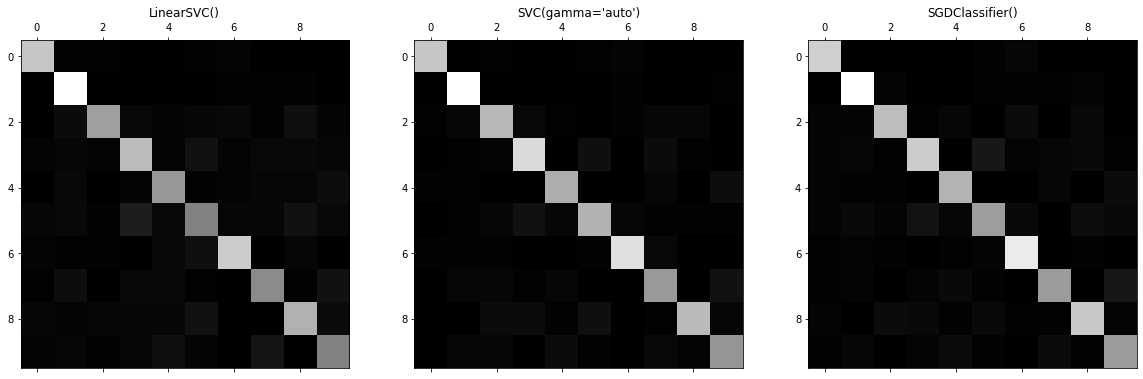

In [27]:

idx = np.random.choice(np.arange(len(y_train)), 1000, replace=False)
X_train_sample = X_train_scaled[idx, :]
y_train_sample = y_train[idx]

models = [
    LinearSVC(),
    SVC(gamma='auto'), 
    SGDClassifier(loss="hinge"), 
]

fig, axs = plt.subplots(1, len(models), figsize=(20, 8))
for i, model in enumerate(models):
    y_train_pred = cross_val_predict(model, X_train_sample, y_train_sample, cv=3)
    conf_mx = confusion_matrix(y_train_sample, y_train_pred)
    accuracy = accuracy_score(y_train_sample, y_train_pred)
    precision = precision_score(y_train_sample, y_train_pred, average="macro")
    recall = recall_score(y_train_sample, y_train_pred, average="macro")
    f1 = f1_score(y_train_sample, y_train_pred, average="macro")
    print(f"model {model} accuracy {accuracy} precision {precision}, recall {recall} f1 {f1}")
    axs[i].matshow(conf_mx, cmap=plt.cm.gray)
    axs[i].set_title(str(model))
plt.show()

In [36]:
# how SVC computes class weights with 'balanced' strategy
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
y_encoded = enc.fit_transform(y_train[:1000])
1000 / (10 * np.bincount(y_encoded))

array([1.03092784, 0.86206897, 1.01010101, 1.07526882, 0.95238095,
       1.08695652, 1.06382979, 0.85470085, 1.14942529, 1.        ])

In [42]:
idx = np.random.choice(np.arange(len(y_train)), 1000, replace=False)
X_train_sample = X_train_scaled[idx, :]
y_train_sample = y_train[idx]

param_distribs = [
    {
        'C': scipy.stats.expon(scale=100), 
        'kernel': ['linear'], 
        'class_weight':['balanced', None],
    },
    {
        'C': scipy.stats.expon(scale=100), 
        'gamma': scipy.stats.expon(scale=.1),
        'kernel': ['rbf'], 
        'class_weight':['balanced', None],
    }
]

svc = SVC()
rnd_search = RandomizedSearchCV(
    svc, 
    param_distributions=param_distribs,
    n_iter=1000,
    cv=5,
    scoring="accuracy",
    verbose=2,
    random_state=42,
    n_jobs=-1,
)
search = rnd_search.fit(X_train_sample, y_train_sample)
print(f"best estimator {search.best_estimator_}\nbest score {search.best_score_}")

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
[CV] END C=159.23005340557225, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=61.47961650819368, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=15.416196746656105, class_weight=balanced, gamma=0.0020799307999138624, kernel=rbf; total time=   0.8s
[CV] END C=128.0129748994866, class_weight=None, gamma=0.0238687625248947, kernel=rbf; total time=   0.9s
[CV] END C=0.709138979446984, class_weight=balanced, gamma=0.034422299255394154, kernel=rbf; total time=   0.9s
[CV] END C=96.33456769068319, class_weight=None, kernel=linear; total time=   0.4s
[CV] END C=96.33456769068319, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=408.8216525459695, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END C=59.87451438464721, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=285.0796878935603, class_weight=None, gamma=0.16523315728128768, kernel=rbf; tota

[CV] END C=151.27241738646856, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=59.02887476385445, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=61.47961650819368, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=128.0129748994866, class_weight=None, gamma=0.0238687625248947, kernel=rbf; total time=   0.9s
[CV] END C=0.709138979446984, class_weight=balanced, gamma=0.034422299255394154, kernel=rbf; total time=   0.9s
[CV] END C=51.05939367995812, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=364.02995536277604, class_weight=balanced, gamma=0.060893468785977505, kernel=rbf; total time=   1.0s
[CV] END C=196.56872807738367, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END C=59.87451438464721, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=1.6095085993823401, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=1.6095085993823401, class_weight=None, kernel=linear; tota

[CV] END C=159.23005340557225, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=59.02887476385445, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=61.47961650819368, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END C=128.0129748994866, class_weight=None, gamma=0.0238687625248947, kernel=rbf; total time=   0.9s
[CV] END C=485.511460488853, class_weight=balanced, gamma=0.03627537294604771, kernel=rbf; total time=   0.9s
[CV] END C=51.05939367995812, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=364.02995536277604, class_weight=balanced, gamma=0.060893468785977505, kernel=rbf; total time=   1.0s
[CV] END C=408.8216525459695, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END C=59.87451438464721, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=1.6095085993823401, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=1.6095085993823401, class_weight=None, kernel=linear; total t

[CV] END C=159.23005340557225, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=151.27241738646856, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=15.416196746656105, class_weight=balanced, gamma=0.0020799307999138624, kernel=rbf; total time=   0.8s
[CV] END C=128.0129748994866, class_weight=None, gamma=0.0238687625248947, kernel=rbf; total time=   0.9s
[CV] END C=0.709138979446984, class_weight=balanced, gamma=0.034422299255394154, kernel=rbf; total time=   0.9s
[CV] END C=364.02995536277604, class_weight=balanced, gamma=0.060893468785977505, kernel=rbf; total time=   1.0s
[CV] END C=196.56872807738367, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END C=285.0796878935603, class_weight=None, gamma=0.16523315728128768, kernel=rbf; total time=   1.0s
[CV] END C=27.57870542258224, class_weight=None, gamma=0.013015223395444864, kernel=rbf; total time=   0.9s
[CV] END C=55.36563610069876, class_weight=None, gamma=0.07912237979817976, 

[CV] END C=159.23005340557225, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=59.02887476385445, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=61.47961650819368, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END C=15.416196746656105, class_weight=balanced, gamma=0.0020799307999138624, kernel=rbf; total time=   0.7s
[CV] END C=485.511460488853, class_weight=balanced, gamma=0.03627537294604771, kernel=rbf; total time=   0.9s
[CV] END C=51.05939367995812, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=51.05939367995812, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=364.02995536277604, class_weight=balanced, gamma=0.060893468785977505, kernel=rbf; total time=   1.0s
[CV] END C=196.56872807738367, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END C=285.0796878935603, class_weight=None, gamma=0.16523315728128768, kernel=rbf; total time=   1.0s
[CV] END C=27.57870542258224, class_weig

[CV] END C=151.27241738646856, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=151.27241738646856, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=61.47961650819368, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=128.0129748994866, class_weight=None, gamma=0.0238687625248947, kernel=rbf; total time=   0.9s
[CV] END C=485.511460488853, class_weight=balanced, gamma=0.03627537294604771, kernel=rbf; total time=   0.9s
[CV] END C=51.05939367995812, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=364.02995536277604, class_weight=balanced, gamma=0.060893468785977505, kernel=rbf; total time=   1.0s
[CV] END C=196.56872807738367, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END C=59.87451438464721, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=1.6095085993823401, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=27.57870542258224, class_weight=None, gamma=0.0130152233954

[CV] END C=159.23005340557225, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=59.02887476385445, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=15.416196746656105, class_weight=balanced, gamma=0.0020799307999138624, kernel=rbf; total time=   0.8s
[CV] END C=485.511460488853, class_weight=balanced, gamma=0.03627537294604771, kernel=rbf; total time=   0.9s
[CV] END C=0.709138979446984, class_weight=balanced, gamma=0.034422299255394154, kernel=rbf; total time=   0.9s
[CV] END C=96.33456769068319, class_weight=None, kernel=linear; total time=   0.4s
[CV] END C=408.8216525459695, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END C=408.8216525459695, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END C=196.56872807738367, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END C=285.0796878935603, class_weight=None, gamma=0.16523315728128768, kernel=rbf; total time=   1.0s
[CV] END C=179.09292843438934, class_

[CV] END C=11.148395887147208, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=11.148395887147208, class_weight=None, kernel=linear; total time=   0.4s
[CV] END C=39.20727193329705, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END C=39.20727193329705, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END C=44.05191413413164, class_weight=None, gamma=0.011659216012385084, kernel=rbf; total time=   1.1s
[CV] END C=43.47428328919698, class_weight=balanced, gamma=0.0006976409181650647, kernel=rbf; total time=   0.5s
[CV] END C=31.390604650246413, class_weight=None, kernel=linear; total time=   0.4s
[CV] END C=31.390604650246413, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=81.6676197331698, class_weight=None, gamma=0.04519744989669624, kernel=rbf; total time=   1.1s
[CV] END C=119.1728976307604, class_weight=balanced, gamma=0.03579304600790468, kernel=rbf; total time=   1.1s
[CV] END C=3.360924912493989, class_weight=None, gam

[CV] END C=76.37615503409346, class_weight=None, gamma=0.02511673382758245, kernel=rbf; total time=   1.1s
[CV] END C=18.427270966282812, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=81.6676197331698, class_weight=None, gamma=0.04519744989669624, kernel=rbf; total time=   1.1s
[CV] END C=609.2605112158448, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=609.2605112158448, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=375.5658599101897, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=114.1641252863987, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END C=114.1641252863987, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=59.38144920353857, class_weight=None, gamma=0.027714481355972622, kernel=rbf; total time=   1.1s
[CV] END C=162.52612252520998, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END C=162.52612252520998, class_weight=balanced, kernel=linear; total t

[CV] END C=118.91370222133257, class_weight=balanced, gamma=0.028673882298329834, kernel=rbf; total time=   1.0s
[CV] END C=286.2138367648132, class_weight=balanced, gamma=0.034214030388705706, kernel=rbf; total time=   1.0s
[CV] END C=11.148395887147208, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=24.646391605155397, class_weight=None, gamma=0.2230813405235561, kernel=rbf; total time=   1.1s
[CV] END C=104.32441512843442, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=104.32441512843442, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=43.47428328919698, class_weight=balanced, gamma=0.0006976409181650647, kernel=rbf; total time=   0.5s
[CV] END C=31.390604650246413, class_weight=None, kernel=linear; total time=   0.4s
[CV] END C=31.390604650246413, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=18.427270966282812, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=29.29162990591085, class_weight=

[CV] END C=44.05191413413164, class_weight=None, gamma=0.011659216012385084, kernel=rbf; total time=   1.1s
[CV] END C=76.37615503409346, class_weight=None, gamma=0.02511673382758245, kernel=rbf; total time=   1.1s
[CV] END C=81.6676197331698, class_weight=None, gamma=0.04519744989669624, kernel=rbf; total time=   1.2s
[CV] END C=609.2605112158448, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END C=609.2605112158448, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END C=375.5658599101897, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=114.1641252863987, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=114.1641252863987, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=59.38144920353857, class_weight=None, gamma=0.027714481355972622, kernel=rbf; total time=   1.1s
[CV] END C=8.430956798241278, class_weight=None, gamma=0.02713331723358058, kernel=rbf; total time=   1.0s
[CV] END C=160.1197582326675, cla

[CV] END C=24.646391605155397, class_weight=None, gamma=0.2230813405235561, kernel=rbf; total time=   1.1s
[CV] END C=104.32441512843442, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=43.47428328919698, class_weight=balanced, gamma=0.0006976409181650647, kernel=rbf; total time=   0.6s
[CV] END C=76.37615503409346, class_weight=None, gamma=0.02511673382758245, kernel=rbf; total time=   1.1s
[CV] END C=81.6676197331698, class_weight=None, gamma=0.04519744989669624, kernel=rbf; total time=   1.1s
[CV] END C=119.1728976307604, class_weight=balanced, gamma=0.03579304600790468, kernel=rbf; total time=   1.1s
[CV] END C=3.360924912493989, class_weight=None, gamma=0.23888609510893405, kernel=rbf; total time=   1.2s
[CV] END C=8.430956798241278, class_weight=None, gamma=0.02713331723358058, kernel=rbf; total time=   1.1s
[CV] END C=409.9747585992971, class_weight=None, gamma=0.07673852499523488, kernel=rbf; total time=   1.1s
[CV] END C=160.1197582326675, class_weight=bala

[CV] END C=18.427270966282812, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=18.427270966282812, class_weight=None, kernel=linear; total time=   0.4s
[CV] END C=29.29162990591085, class_weight=None, kernel=linear; total time=   0.4s
[CV] END C=119.1728976307604, class_weight=balanced, gamma=0.03579304600790468, kernel=rbf; total time=   1.1s
[CV] END C=375.5658599101897, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=3.360924912493989, class_weight=None, gamma=0.23888609510893405, kernel=rbf; total time=   1.1s
[CV] END C=59.38144920353857, class_weight=None, gamma=0.027714481355972622, kernel=rbf; total time=   1.1s
[CV] END C=162.52612252520998, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END C=409.9747585992971, class_weight=None, gamma=0.07673852499523488, kernel=rbf; total time=   1.1s
[CV] END C=119.01119999474501, class_weight=balanced, gamma=0.08937784045945835, kernel=rbf; total time=   1.2s
[CV] END C=165.81085759775226, cl

[CV] END C=212.4169814240007, class_weight=None, gamma=0.16508870804845696, kernel=rbf; total time=   1.0s
[CV] END C=39.20727193329705, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END C=39.20727193329705, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=44.05191413413164, class_weight=None, gamma=0.011659216012385084, kernel=rbf; total time=   1.1s
[CV] END C=76.37615503409346, class_weight=None, gamma=0.02511673382758245, kernel=rbf; total time=   1.1s
[CV] END C=18.427270966282812, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=29.29162990591085, class_weight=None, kernel=linear; total time=   0.4s
[CV] END C=29.29162990591085, class_weight=None, kernel=linear; total time=   0.4s
[CV] END C=119.1728976307604, class_weight=balanced, gamma=0.03579304600790468, kernel=rbf; total time=   1.1s
[CV] END C=3.360924912493989, class_weight=None, gamma=0.23888609510893405, kernel=rbf; total time=   1.1s
[CV] END C=8.430956798241278, class_

[CV] END C=76.37615503409346, class_weight=None, gamma=0.02511673382758245, kernel=rbf; total time=   1.1s
[CV] END C=81.6676197331698, class_weight=None, gamma=0.04519744989669624, kernel=rbf; total time=   1.1s
[CV] END C=609.2605112158448, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=375.5658599101897, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=3.360924912493989, class_weight=None, gamma=0.23888609510893405, kernel=rbf; total time=   1.1s
[CV] END C=59.38144920353857, class_weight=None, gamma=0.027714481355972622, kernel=rbf; total time=   1.2s
[CV] END C=162.52612252520998, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END C=409.9747585992971, class_weight=None, gamma=0.07673852499523488, kernel=rbf; total time=   1.1s
[CV] END C=119.01119999474501, class_weight=balanced, gamma=0.08937784045945835, kernel=rbf; total time=   1.1s
[CV] END C=165.81085759775226, class_weight=None, kernel=linear; total time=   0.4s
[CV] END C=

[CV] END C=66.62277457563502, class_weight=None, kernel=linear; total time=   0.4s
[CV] END C=66.62277457563502, class_weight=None, kernel=linear; total time=   0.4s
[CV] END C=147.78921549962854, class_weight=balanced, gamma=0.10248442087373909, kernel=rbf; total time=   1.1s
[CV] END C=319.6009135921479, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=95.43827664217433, class_weight=None, gamma=0.08824446091085542, kernel=rbf; total time=   1.1s
[CV] END C=10.624379787661027, class_weight=balanced, gamma=0.0018276180406497236, kernel=rbf; total time=   0.8s
[CV] END C=89.88509558224926, class_weight=None, gamma=0.08327154639433977, kernel=rbf; total time=   1.1s
[CV] END C=147.51110110844184, class_weight=balanced, gamma=0.0933220857034015, kernel=rbf; total time=   1.2s
[CV] END C=241.5599248234803, class_weight=balanced, gamma=0.01201787045517842, kernel=rbf; total time=   1.1s
[CV] END C=18.094711421379568, class_weight=None, kernel=linear; total time=   0.4s
[CV] 

[CV] END C=125.19875569872406, class_weight=balanced, gamma=0.2093667344385938, kernel=rbf; total time=   1.1s
[CV] END C=92.62346897307248, class_weight=balanced, gamma=0.159600536332649, kernel=rbf; total time=   1.1s
[CV] END C=83.35785457914348, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=83.35785457914348, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=91.3867083228071, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=319.6009135921479, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=95.43827664217433, class_weight=None, gamma=0.08824446091085542, kernel=rbf; total time=   1.1s
[CV] END C=89.88509558224926, class_weight=None, gamma=0.08327154639433977, kernel=rbf; total time=   1.1s
[CV] END C=156.1050863428892, class_weight=balanced, gamma=0.12283974533925182, kernel=rbf; total time=   1.1s
[CV] END C=8.04739549267873, class_weight=None, gamma=0.2723676885762475, kernel=rbf; total time=   1.1s
[CV] END C=241.5599

[CV] END C=66.62277457563502, class_weight=None, kernel=linear; total time=   0.4s
[CV] END C=66.62277457563502, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=147.78921549962854, class_weight=balanced, gamma=0.10248442087373909, kernel=rbf; total time=   1.1s
[CV] END C=319.6009135921479, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=25.793038658692463, class_weight=balanced, gamma=0.061990750632116336, kernel=rbf; total time=   1.1s
[CV] END C=10.624379787661027, class_weight=balanced, gamma=0.0018276180406497236, kernel=rbf; total time=   0.8s
[CV] END C=89.88509558224926, class_weight=None, gamma=0.08327154639433977, kernel=rbf; total time=   1.1s
[CV] END C=147.51110110844184, class_weight=balanced, gamma=0.0933220857034015, kernel=rbf; total time=   1.1s
[CV] END C=8.04739549267873, class_weight=None, gamma=0.2723676885762475, kernel=rbf; total time=   1.1s
[CV] END C=18.094711421379568, class_weight=None, kernel=linear; total time=   0.3s
[CV] 

[CV] END C=83.35785457914348, class_weight=None, kernel=linear; total time=   0.4s
[CV] END C=91.3867083228071, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=91.3867083228071, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=25.793038658692463, class_weight=balanced, gamma=0.061990750632116336, kernel=rbf; total time=   1.1s
[CV] END C=95.43827664217433, class_weight=None, gamma=0.08824446091085542, kernel=rbf; total time=   1.1s
[CV] END C=156.1050863428892, class_weight=balanced, gamma=0.12283974533925182, kernel=rbf; total time=   1.1s
[CV] END C=147.51110110844184, class_weight=balanced, gamma=0.0933220857034015, kernel=rbf; total time=   1.1s
[CV] END C=241.5599248234803, class_weight=balanced, gamma=0.01201787045517842, kernel=rbf; total time=   1.1s
[CV] END C=181.70205957571818, class_weight=balanced, gamma=0.20394239312268636, kernel=rbf; total time=   1.2s
[CV] END C=47.69165861839353, class_weight=balanced, kernel=linear; total time=   0.3s
[

[CV] END C=147.51110110844184, class_weight=balanced, gamma=0.0933220857034015, kernel=rbf; total time=   1.2s
[CV] END C=241.5599248234803, class_weight=balanced, gamma=0.01201787045517842, kernel=rbf; total time=   1.1s
[CV] END C=18.094711421379568, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=181.70205957571818, class_weight=balanced, gamma=0.20394239312268636, kernel=rbf; total time=   1.2s
[CV] END C=92.56381121571583, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=53.529692552860745, class_weight=None, kernel=linear; total time=   0.4s
[CV] END C=256.343352030371, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=3.3398233785630635, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=28.53201210659368, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END C=28.53201210659368, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END C=37.320099444518604, class_weight=balanced, gamma=0.0

[CV] END C=10.624379787661027, class_weight=balanced, gamma=0.0018276180406497236, kernel=rbf; total time=   0.8s
[CV] END C=89.88509558224926, class_weight=None, gamma=0.08327154639433977, kernel=rbf; total time=   1.1s
[CV] END C=147.51110110844184, class_weight=balanced, gamma=0.0933220857034015, kernel=rbf; total time=   1.1s
[CV] END C=8.04739549267873, class_weight=None, gamma=0.2723676885762475, kernel=rbf; total time=   1.1s
[CV] END C=18.094711421379568, class_weight=None, kernel=linear; total time=   0.4s
[CV] END C=25.798816073225368, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=25.798816073225368, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=47.69165861839353, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END C=23.01427491215707, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=53.529692552860745, class_weight=None, kernel=linear; total time=   0.4s
[CV] END C=65.5537337409571, class_weight=bal

[CV] END C=8.04739549267873, class_weight=None, gamma=0.2723676885762475, kernel=rbf; total time=   1.1s
[CV] END C=241.5599248234803, class_weight=balanced, gamma=0.01201787045517842, kernel=rbf; total time=   1.1s
[CV] END C=181.70205957571818, class_weight=balanced, gamma=0.20394239312268636, kernel=rbf; total time=   1.2s
[CV] END C=23.01427491215707, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END C=92.56381121571583, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=256.343352030371, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END C=65.5537337409571, class_weight=balanced, gamma=0.060187777349233945, kernel=rbf; total time=   1.2s
[CV] END C=37.320099444518604, class_weight=balanced, gamma=0.0868902383785272, kernel=rbf; total time=   1.1s
[CV] END C=24.85860005031958, class_weight=None, gamma=0.10892681970359891, kernel=rbf; total time=   1.1s
[CV] END C=37.097227436366985, class_weight=None, kernel=linear; total time=   0.3s

[CV] END C=181.70205957571818, class_weight=balanced, gamma=0.20394239312268636, kernel=rbf; total time=   1.2s
[CV] END C=23.01427491215707, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END C=92.56381121571583, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=256.343352030371, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END C=3.3398233785630635, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=3.3398233785630635, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=28.53201210659368, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END C=18.093849457915503, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END C=24.85860005031958, class_weight=None, gamma=0.10892681970359891, kernel=rbf; total time=   1.1s
[CV] END C=371.07699393258196, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=76.5867817826549, class_weight=None, gamma=0.06975468656582261, kernel=

[CV] END C=19.846366743012045, class_weight=balanced, gamma=0.038002561105678706, kernel=rbf; total time=   1.2s
[CV] END C=50.64667847630503, class_weight=None, gamma=0.33558043078199096, kernel=rbf; total time=   1.1s
[CV] END C=73.75799499141425, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=73.75799499141425, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END C=75.98106005262645, class_weight=balanced, gamma=0.0030431980919971274, kernel=rbf; total time=   0.8s
[CV] END C=131.24101778111367, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=131.24101778111367, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=26.730613676333824, class_weight=balanced, gamma=0.019498109905864383, kernel=rbf; total time=   1.1s
[CV] END C=1.7671211057748513, class_weight=None, gamma=0.09619348555509416, kernel=rbf; total time=   1.2s
[CV] END C=199.95871787946442, class_weight=balanced, gamma=0.00308583177339052, kernel=rbf; tot

[CV] END C=73.75799499141425, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=75.98106005262645, class_weight=balanced, gamma=0.0030431980919971274, kernel=rbf; total time=   0.9s
[CV] END C=15.495042191501964, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=131.24101778111367, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=26.730613676333824, class_weight=balanced, gamma=0.019498109905864383, kernel=rbf; total time=   1.1s
[CV] END C=108.36222538433344, class_weight=balanced, gamma=0.2893432387380273, kernel=rbf; total time=   1.0s
[CV] END C=199.95871787946442, class_weight=balanced, gamma=0.00308583177339052, kernel=rbf; total time=   0.8s
[CV] END C=158.72380221272732, class_weight=None, gamma=0.11285975438794892, kernel=rbf; total time=   1.1s
[CV] END C=42.859096209058, class_weight=None, gamma=0.7441722909704406, kernel=rbf; total time=   1.2s
[CV] END C=38.28892028724511, class_weight=balanced, gamma=0.05224056824545973, 

[CV] END C=131.24101778111367, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=131.24101778111367, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=26.730613676333824, class_weight=balanced, gamma=0.019498109905864383, kernel=rbf; total time=   1.1s
[CV] END C=108.36222538433344, class_weight=balanced, gamma=0.2893432387380273, kernel=rbf; total time=   1.0s
[CV] END C=199.95871787946442, class_weight=balanced, gamma=0.00308583177339052, kernel=rbf; total time=   0.9s
[CV] END C=282.81074590476493, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=282.81074590476493, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=109.95272580977253, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=38.28892028724511, class_weight=balanced, gamma=0.05224056824545973, kernel=rbf; total time=   1.2s
[CV] END C=11.553390258993781, class_weight=None, kernel=linear; total time=   0.4s
[CV] END C=11.553390258993781, class_

[CV] END C=1.7532591766733712, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=361.5545281021227, class_weight=balanced, gamma=0.06064922690920095, kernel=rbf; total time=   1.1s
[CV] END C=15.495042191501964, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=132.01281092351172, class_weight=None, gamma=0.350363039022921, kernel=rbf; total time=   1.1s
[CV] END C=26.730613676333824, class_weight=balanced, gamma=0.019498109905864383, kernel=rbf; total time=   1.0s
[CV] END C=1.7671211057748513, class_weight=None, gamma=0.09619348555509416, kernel=rbf; total time=   1.1s
[CV] END C=158.72380221272732, class_weight=None, gamma=0.11285975438794892, kernel=rbf; total time=   1.2s
[CV] END C=109.95272580977253, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END C=42.859096209058, class_weight=None, gamma=0.7441722909704406, kernel=rbf; total time=   1.2s
[CV] END C=139.60528713387262, class_weight=balanced, gamma=0.08370551059265524, kernel=rb

[CV] END C=38.15470150372953, class_weight=balanced, kernel=linear; total time=   0.4s
[CV] END C=47.107981113254745, class_weight=None, kernel=linear; total time=   0.4s
[CV] END C=47.107981113254745, class_weight=None, kernel=linear; total time=   0.3s
[CV] END C=104.71817812587167, class_weight=balanced, gamma=0.03924291909431879, kernel=rbf; total time=   1.2s
[CV] END C=79.5179289628004, class_weight=balanced, gamma=0.027121064873197792, kernel=rbf; total time=   1.1s
[CV] END C=88.44571105043644, class_weight=None, gamma=0.1103261475071069, kernel=rbf; total time=   1.2s
[CV] END C=142.43881136909863, class_weight=balanced, gamma=0.04776903447799, kernel=rbf; total time=   1.1s
[CV] END C=168.07528796116912, class_weight=balanced, kernel=linear; total time=   0.3s
[CV] END C=64.75917186724301, class_weight=balanced, gamma=0.14476731287868813, kernel=rbf; total time=   1.1s
[CV] END C=137.38746703038944, class_weight=None, gamma=0.31127987250042055, kernel=rbf; total time=   1.3s


[CV] END C=302.5749509979848, class_weight=None, gamma=0.06523543915152495, kernel=rbf; total time=   1.1s
[CV] END C=16.133358050178696, class_weight=None, gamma=0.08679110548652708, kernel=rbf; total time=   1.1s
[CV] END C=64.75917186724301, class_weight=balanced, gamma=0.14476731287868813, kernel=rbf; total time=   1.3s
[CV] END C=227.02562458245458, class_weight=balanced, kernel=linear; total time=   0.5s
[CV] END C=309.35662963049907, class_weight=None, gamma=0.2617769166223719, kernel=rbf; total time=   1.5s
[CV] END C=74.04164235383489, class_weight=None, gamma=0.036714378716127864, kernel=rbf; total time=   1.2s
[CV] END C=75.98431491043594, class_weight=None, kernel=linear; total time=   0.4s
[CV] END C=9.390014743779894, class_weight=None, gamma=0.12593117246481014, kernel=rbf; total time=   1.3s
[CV] END C=196.19486336572606, class_weight=balanced, kernel=linear; total time=   0.5s
[CV] END C=157.7005854316612, class_weight=balanced, gamma=0.029647096009248416, kernel=rbf; 

best estimator SVC(C=50.23310023986688, gamma=0.0005537420375935475)
best score 0.891


In [43]:
print(f"best estimator {search.best_estimator_}\nbest score {search.best_score_}")

best estimator SVC(C=50.23310023986688, gamma=0.0005537420375935475)
best score 0.891


In [48]:
search.best_estimator_.fit(X_train_scaled, y_train)

SVC(C=50.23310023986688, gamma=0.0005537420375935475)

In [50]:
y_train_pred = search.best_estimator_.predict(X_train_scaled)
accuracy_score(y_train, y_train_pred)

0.9994333333333333

In [52]:
y_test_pred = search.best_estimator_.predict(X_test_scaled)

In [53]:
accuracy_score(y_test, y_test_pred)

0.9732